# Poisson Regression

Gaussian process models can be incredibly flexbile for modelling non-Gaussian data. One such example is in the case of count data $\mathbf{y}$, which can be modelled with a __Poisson model__ with a latent Gaussian process.
$$
\mathbf{y} \ | \ \mathbf{f} \sim \prod_{i=1}^{n} \frac{\lambda_i^{y_i}\exp\{-\lambda_i\}}{y_i!},
$$
where $\lambda_i=\exp(f_i)$ and $f_i$ is the latent Gaussian process.


In [ ]:
#Load the package
using GaussianProcesses, Random, Distributions

#Simulate the data
Random.seed!(203617)
n = 20
X = collect(range(-3,stop=3,length=n));
f = 2*cos.(2*X);
Y = [rand(Poisson(exp.(f[i]))) for i in 1:n];

#Plot the data using the Plots.jl package with the GR backend
using Plots
gr()
scatter(X,Y,leg=false, fmt=:png)

In [15]:
#GP set-up
k = Matern(3/2,0.0,0.0)   # Matern 3/2 kernel
l = PoisLik()             # Poisson likelihood
gpmc = GP(X, vec(Y), MeanZero(), k, l)
gpvi = GP(X, vec(Y), MeanZero(), k, l)

GP Approximate object:
  Dim = 1
  Number of observations = 20
  Mean function:
    Type: MeanZero, Params: Float64[]
  Kernel:
    Type: Mat32Iso{Float64}, Params: [0.0, 0.0]
  Likelihood:
    Type: PoisLik, Params: Any[]
  Input observations = 
[-3.0 -2.68421 … 2.68421 3.0]
  Output observations = [3, 3, 1, 0, 0, 0, 0, 0, 3, 4, 7, 3, 1, 0, 0, 1, 0, 3, 4, 4]
  Log-posterior = -65.397

In [16]:
set_priors!(gpmc.kernel,[Normal(-2.0,4.0),Normal(-2.0,4.0)])
@time samples = mcmc(gpmc; nIter=10000);

Number of iterations = 10000, Thinning = 1, Burn-in = 1 
Step size = 0.100000, Average number of leapfrog steps = 10.000700 
Number of function calls: 100008
Acceptance rate: 0.813400 
  2.943728 seconds (19.95 M allocations: 1.821 GiB, 11.65% gc time)


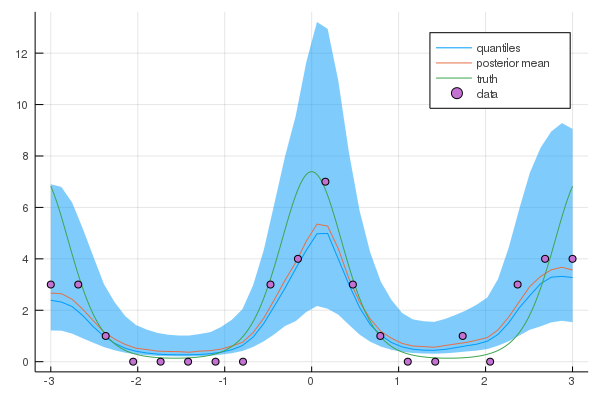

In [17]:
#Sample predicted values
xtest = range(minimum(gpmc.x),stop=maximum(gpmc.x),length=50);
ymean = [];
fsamples = Array{Float64}(undef,size(samples,2), length(xtest));
for i in 1:size(samples,2)
    set_params!(gpmc,samples[:,i])
    update_target!(gpmc)
    push!(ymean, predict_y(gpmc,xtest)[1])
    fsamples[i,:] = rand(gpmc, xtest)
end

#Predictive plots

q10 = [quantile(fsamples[:,i], 0.1) for i in 1:length(xtest)]
q50 = [quantile(fsamples[:,i], 0.5) for i in 1:length(xtest)]
q90 = [quantile(fsamples[:,i], 0.9) for i in 1:length(xtest)]
plot(xtest,exp.(q50),ribbon=(exp.(q10), exp.(q90)),leg=true, fmt=:png, label="quantiles")
plot!(xtest,mean(ymean), label="posterior mean")
xx = range(-3,stop=3,length=1000);
f_xx = 2*cos.(2*xx);
plot!(xx, exp.(f_xx), label="truth")
scatter!(X,Y, label="data")

### Alternatives to MCMC

As an alternative to MCMC, the practioner is also able to compute the approximate posterior using variational inference. This is done through the approach described in [Khan et. al.](http://papers.nips.cc/paper/4535-fast-bayesian-inference-for-non-conjugate-gaussian-process-regression). An approximate density $$q(\mathbf{x})=(2 \pi)^{-N / 2}|\mathbf{\Sigma}|^{-\frac{1}{2}} e^{-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^{\top} \boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})}$$ is used to replace the true posterior.

Syntactically, this can be found in a similar vein to mcmc by simply using the following statements.

In [18]:
@time Q = vi(gpvi);

Number of iterations = 1, Thinning = 1, Burn-in = 1 
Step size = 0.100000, Average number of leapfrog steps = 9.000000 
Number of function calls: 10
Acceptance rate: 1.000000 
  0.856368 seconds (427.06 k allocations: 184.423 MiB, 5.56% gc time)


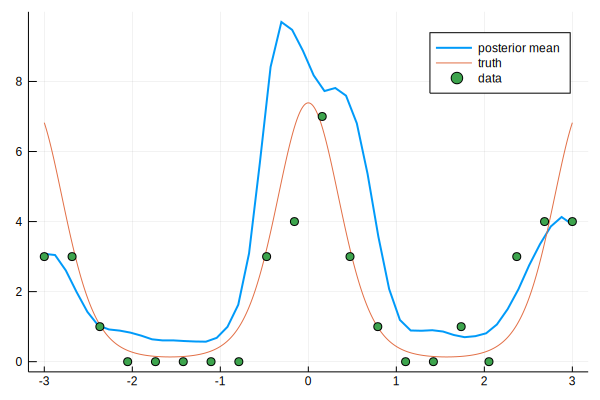

In [19]:
nsamps = 500
ymean = [];
visamples = Array{Float64}(undef, nsamps, size(xtest, 1))

for i in 1:nsamps
    visamples[i, :] = rand(gpvi, xtest, Q)
    push!(ymean, predict_y(gpvi, xtest)[1])
end

q10 = [quantile(visamples[i,:], 0.1) for i in 1:length(xtest)]
q50 = [quantile(visamples[i,:], 0.5) for i in 1:length(xtest)]
q90 = [quantile(visamples[i,:], 0.9) for i in 1:length(xtest)]
# plot(xtest, exp.(q50), ribbon=(exp.(q10), exp.(q90)), leg=true, fmt=:png, label="quantiles")
plot(xtest, mean(ymean), label="posterior mean", w=2)
xx = range(-3,stop=3,length=1000);
f_xx = 2*cos.(2*xx);
plot!(xx, exp.(f_xx), label="truth")
scatter!(X,Y, label="data")